# <span style="color:Green">*** GIZMO ***</span>

_______

## Project Overview

### Objective: 
Find out if sentiment analysis impacts our model. Utilizing machine learning techniques to analyze financial news headlines for predicting sentiment and its impact on price fluctuations in the US economy and stock market.

### Business Purpose: 
Investment strategies may be significantly improved by factoring public sentiment of financial performance. To test our hypothesis, we develop a trading tool that accounts for public sentiment from Tesla (TSLA) and market trends in the investment strategy, to determine whether it improves trading returns.

______

# <span style="color:Blue">Data Preparation</span>

## Import Dependendies

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import re
import yfinance as y
import matplotlib.pyplot as plt

from pathlib import Path
from textblob import TextBlob
from pandas.tseries.offsets import DateOffset
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import tree, svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Ignore all warnings within this code block
import warnings
warnings.filterwarnings("ignore")

## Import Aggregated Data

In [2]:
# All data was acquired, combined and cleaned. This is the import of the "combined_csv" the final extract of that preprocessing.
sentiment_df=pd.read_csv(Path("../Resources/combined_csv.csv"))
sentiment_df.head()

,Time,Headline,SP500 Close,Volume,TSLA Close,Volume.1
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0


## Obtain Sentiment Analysis Features

In [3]:
# obtain polarity and subjectivity scores (potentially factor volume of information in the sentiment analysis)
# create a function to calculate the subjectivity
def calculate_subjectivity(headlines):
    return TextBlob(headlines).sentiment.subjectivity

# create a function to calculate the subjectivity
def calculate_polarity(headlines):
    return TextBlob(headlines).sentiment.polarity

In [4]:
# create two new columns "Subjectivity" and "Polarity"
sentiment_df["Subjectivity"] = sentiment_df["Headline"].apply(calculate_subjectivity)
sentiment_df["Polarity"] = sentiment_df["Headline"].apply(calculate_polarity)

In [5]:
# create function to get the sentiment scores 
def get_scores(headlines):
    get_score= SentimentIntensityAnalyzer()
    sentiment=get_score.polarity_scores(headlines)
    return sentiment

In [6]:
# get daily sentiment scores
compound = []
neg = []
pos = []
neu = []
score = 0

for x in range(0, len(sentiment_df["Headline"])):
    score = get_scores(sentiment_df["Headline"][x])
    compound.append(score["compound"])
    neg.append(score["neg"])
    neu.append(score["neu"])
    pos.append(score["pos"])

In [7]:
# Add Column with sentiment scores
sentiment_df["compound"]= compound
sentiment_df["neg"]= neg
sentiment_df["pos"]= pos
sentiment_df["neu"]= neu

# Assuming you have a DataFrame named 'sentiment_df'
sentiment_df.rename(columns={'Volume.1': 'Tvolume'}, inplace=True)

#Display Dataframe
sentiment_df

,Time,Headline,SP500 Close,Volume,TSLA Close,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0,0.349438,-0.000624,-0.9425,0.122,0.075,0.804
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0,0.303711,-0.043869,-0.9760,0.127,0.027,0.846
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0,0.405042,-0.020270,-0.8761,0.104,0.077,0.818
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0,0.522302,-0.036371,0.4404,0.094,0.113,0.793
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0,0.429320,0.038917,-0.2362,0.096,0.108,0.797
...,...,...,...,...,...,...,...,...,...,...,...,...
642,2020-07-13,"Luckin Coffee ousts chairman Lu, names Guo as ...",314.839996,102997500.0,99.804001,584781000.0,0.414809,0.140556,0.9773,0.100,0.123,0.777
643,2020-07-14,"Google hit with 600,000 euro Belgian privacy f...",318.920013,93657000.0,101.120003,351271500.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814
644,2020-07-15,Oil climbs 2% on U.S. stock draw but gains cap...,321.850006,87196500.0,103.067329,245517000.0,0.387709,0.012013,0.5514,0.127,0.128,0.745
645,2020-07-16,Morgan Stanley posts record profit on trading ...,320.790009,54622500.0,100.042664,214512000.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771


## Calculate and Assign Features

### Baseline

Dropped the following features from the dataframe: "SP500 Close" and "Volume". Set the simple moving average (SMA) windows as the following: "sma_short" = 7 , "sma_long" = 30.

In [8]:
# Calculate daily returns 
sentiment_df["daily returns"]= sentiment_df["TSLA Close"].pct_change()
sentiment_df.drop(columns=["SP500 Close", "Volume"], inplace = True)
sentiment_df= sentiment_df.set_index("Time")
sentiment_df.index= pd.to_datetime(sentiment_df.index)

# create label column add 1 when daily returns is positive and 0 when it is negative
sentiment_df["label"]= 0
sentiment_df.loc[(sentiment_df["daily returns"]> 0), 'label'] = 1

# make a copy of the sentiment_df for adjusted models
sentiment_2_df = sentiment_df.copy()

# verify that label is int
display(sentiment_df["label"].dtype)
display(sentiment_2_df["label"].dtype)

dtype('int64')

dtype('int64')

In [9]:
# calculate SMA short and SMA slow
sentiment_df["sma_short"]= sentiment_df.rolling(7)["TSLA Close"].mean()
sentiment_df["sma_long"]= sentiment_df.rolling(30)["TSLA Close"].mean()
sentiment_df.dropna(inplace=True)

### Adjusted

Set the simple moving average (SMA) windows as the following: "sma_short" = 5 , "sma_long" = 20.

In [10]:
# calculate SMA short and SMA slow
sentiment_2_df["sma_short"]= sentiment_df.rolling(5)["TSLA Close"].mean()
sentiment_2_df["sma_long"]= sentiment_df.rolling(20)["TSLA Close"].mean()
sentiment_2_df.dropna(inplace=True)

## Assign X Features and y Variable

### Baseline

In [11]:
# display dataframe columns for features
sentiment_df.columns

Index(['Headline', 'TSLA Close', 'Tvolume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'daily returns', 'label', 'sma_short',
       'sma_long'],
      dtype='object')

In [12]:
# create features variable with columns for X and assign the y variable
#TSLA Version
features=['Tvolume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'sma_short',
       'sma_long']

X = sentiment_df[features].shift().dropna().copy()
y=(sentiment_df['daily returns']>0).astype(int)[1:]

display(X.tail())
display(y.tail())

,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2020-07-13,350064000.0,0.368474,0.074615,-0.4037,0.100,0.103,0.797,89.471810,69.838823
2020-07-14,584781000.0,0.414809,0.140556,0.9773,0.100,0.123,0.777,93.066382,71.310067
2020-07-15,351271500.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814,96.001050,72.684956
2020-07-16,245517000.0,0.387709,0.012013,0.5514,0.127,0.128,0.745,97.662287,74.161511
2020-07-17,214512000.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771,98.717334,75.534134


Time
2020-07-13    0
2020-07-14    1
2020-07-15    1
2020-07-16    0
2020-07-17    1
Name: daily returns, dtype: int64

In [13]:
# verify x and y are same length
display(len(X))
display(len(y))

617

617

### Adjusted

Dropped the following features: "XXXXXXX" and "XXXXX".

In [14]:
# create features variable with columns for X and assign the y variable
#TSLA Version
features_2=['Tvolume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'sma_short',
       'sma_long']

X2 = sentiment_2_df[features_2].shift().dropna().copy()
y2=(sentiment_2_df['daily returns']>0).astype(int)[1:]

display(X2.tail())
display(y2.tail())

,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2020-07-13,350064000.0,0.368474,0.074615,-0.4037,0.100,0.103,0.797,94.216669,74.304434
2020-07-14,584781000.0,0.414809,0.140556,0.9773,0.100,0.123,0.777,95.889735,76.177034
2020-07-15,351271500.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814,97.582269,77.930034
2020-07-16,245517000.0,0.387709,0.012013,0.5514,0.127,0.128,0.745,99.984001,79.809634
2020-07-17,214512000.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771,101.402133,81.505800


Time
2020-07-13    0
2020-07-14    1
2020-07-15    1
2020-07-16    0
2020-07-17    1
Name: daily returns, dtype: int64

In [15]:
# verify x and y are same length
display(len(X2))
display(len(y2))

598

598

## Split and Scale Data

### Baseline

Set the training data offset to 3 months.

In [16]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(f'Training Begin Date:{training_begin}')

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(f'Training End Date:{training_end}')

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

Training Begin Date:2018-02-02 00:00:00
Training End Date:2018-05-02 00:00:00


,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2018-02-02,62965500.0,0.374069,0.058918,-0.9927,0.186,0.114,0.700,23.098000,22.354667
2018-02-05,55572000.0,0.400000,-0.073333,-0.1901,0.058,0.075,0.867,23.077619,22.365511
2018-02-06,66961500.0,0.468833,0.014328,-0.8130,0.114,0.075,0.811,23.034667,22.370022
2018-02-07,76326000.0,0.371886,0.014133,-0.9798,0.127,0.080,0.793,22.950096,22.381111
2018-02-08,104538000.0,0.423801,-0.000789,-0.8934,0.095,0.052,0.853,22.906953,22.410756


In [17]:
## Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Adjusted

Set the training data offset to XXX months.

In [18]:
# Select the start of the training period
training_2_begin = X2.index.min()

# Display the training begin date
print(f'Training Begin Date:{training_2_begin}')

# Select the ending period for the training data with an offset of 3 months
training_2_end = X2.index.min() + DateOffset(months=3)

# Display the training end date
print(f'Training End Date:{training_2_end}')

# Generate the X_train and y_train DataFrames
X2_train = X2.loc[training_2_begin:training_2_end]
y2_train = y2.loc[training_2_begin:training_2_end]

# Review the X_train DataFrame
X2_train.head()

# Generate the X_test and y_test DataFrames
X2_test = X2.loc[training_2_end+DateOffset(hours=1):]
y2_test = y2.loc[training_2_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X2_train.head()

Training Begin Date:2018-03-05 00:00:00
Training End Date:2018-06-05 00:00:00


,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2018-03-05,76392000.0,0.409287,0.053732,0.0348,0.107,0.101,0.791,22.900266,22.407200
2018-03-06,57357000.0,0.474033,0.159805,-0.4033,0.129,0.138,0.733,22.579333,22.354200
2018-03-07,64285500.0,0.443333,0.158485,-0.7898,0.136,0.119,0.745,22.275467,22.302367
2018-03-08,75109500.0,0.433130,0.094159,-0.9816,0.142,0.091,0.767,22.132000,22.299600
2018-03-09,53493000.0,0.379947,-0.025936,-0.9292,0.151,0.103,0.746,22.107600,22.283367


In [19]:
# Scale the features DataFrames

# Apply the scaler model to fit the X2-train data
X2_scaler = scaler.fit(X2_train)

# Transform the X2_train and X2_test DataFrames using the X2_scaler
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

# <span style="color:blue">Machine Learning</span>

## Model #1 Support Vector Machines (SVM)

### Run Model Classifier: C-Support Vector Classification (SVC) 

#### Baseline Model

In [20]:
## Use a classifier to predict future results

# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Create a predictions DataFrame
predictions_sentiment_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_sentiment_df['Actual Returns'] = sentiment_df['daily returns'].pct_change()

# Add the strategy returns to the DataFrame
predictions_sentiment_df['Strategy Returns'] = predictions_sentiment_df['Actual Returns'] * predictions_sentiment_df['Predicted']

# Review the DataFrame
display(predictions_sentiment_df.head())
display(predictions_sentiment_df.tail())

,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-05-03,1,-14.521676,-14.521676
2018-05-04,1,-1.611136,-1.611136
2018-05-07,1,-0.129101,-0.129101
2018-05-08,1,-1.089527,-1.089527
2018-05-09,0,-7.115971,-0.000000


,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-07-13,1,-1.285677,-1.285677
2020-07-14,1,-1.427979,-1.427979
2020-07-15,1,0.460472,0.460472
2020-07-16,1,-2.523894,-2.523894
2020-07-17,1,-1.004542,-1.004542


<Axes: title={'center': 'SVC Model- Baseline'}, xlabel='Time'>

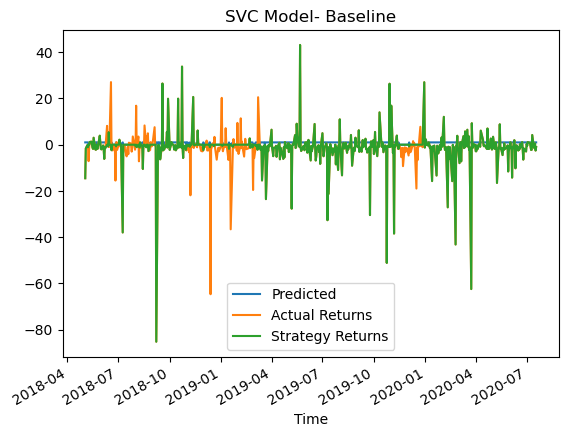

In [21]:
# plot
predictions_sentiment_df.plot(title='SVC Model- Baseline')

# Save the plot as a JPG file
# plt.savefig('TSLA SVC Model.jpg', format='jpg')

In [22]:
# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

           0       0.50      0.28      0.36       268
           1       0.52      0.74      0.61       288

    accuracy                           0.52       556
   macro avg       0.51      0.51      0.48       556
weighted avg       0.51      0.52      0.49       556



#### Adjusted Model

In [23]:
## Use a classifier to predict future results

# From SVM, instantiate SVC classifier model instance
svm_2_model = svm.SVC()

# Fit the model to the data using the training data
svm_2_model = svm_2_model.fit(X2_train_scaled, y2_train)
 
# Use the testing data to make the model predictions
svm_2_pred = svm_2_model.predict(X2_test_scaled)

# Review the model's predicted values
svm_2_pred[:10]

# Use a classification report to evaluate the model using the predictions and testing data
svm_2_testing_report = classification_report(y2_test, svm_2_pred)

# Create a predictions DataFrame
predictions_sentiment_2_df = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_2_df['Predicted'] = svm_2_pred

# Add the actual returns to the DataFrame
predictions_sentiment_2_df['Actual Returns'] = sentiment_df['daily returns'].pct_change()

# Add the strategy returns to the DataFrame
predictions_sentiment_2_df['Strategy Returns'] = predictions_sentiment_2_df['Actual Returns'] * predictions_sentiment_2_df['Predicted']

# Review the DataFrame
display(predictions_sentiment_2_df.head())
display(predictions_sentiment_2_df.tail())

,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-06-06,0,-6.154480,-0.000000
2018-06-07,1,-1.109524,-1.109524
2018-06-08,0,-1.465382,-0.000000
2018-06-11,0,8.151897,0.000000
2018-06-12,0,-0.293207,-0.000000


,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-07-13,0,-1.285677,-0.0
2020-07-14,0,-1.427979,-0.0
2020-07-15,0,0.460472,0.0
2020-07-16,0,-2.523894,-0.0
2020-07-17,0,-1.004542,-0.0


<Axes: title={'center': 'SVC Model - Adjusted'}, xlabel='Time'>

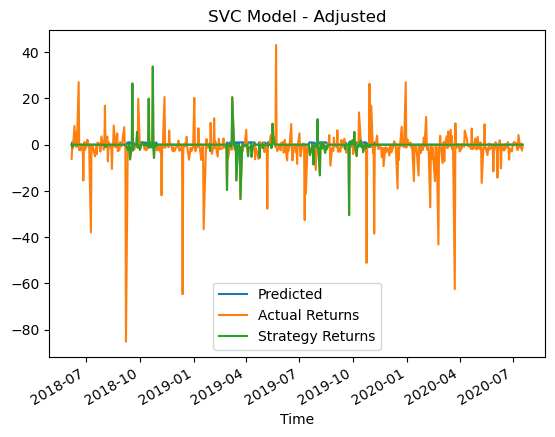

In [24]:
# plot
predictions_sentiment_2_df.plot(title='SVC Model - Adjusted')

# Save the plot as a JPG file
# plt.savefig('TSLA SVC Model Adjusted.jpg', format='jpg')

In [25]:
# Print the classification report
print(svm_2_testing_report)

              precision    recall  f1-score   support

           0       0.46      0.79      0.58       256
           1       0.42      0.14      0.21       277

    accuracy                           0.45       533
   macro avg       0.44      0.46      0.40       533
weighted avg       0.44      0.45      0.39       533



## Model #2 Linear Discriminant Analysis (LDA)

### Run Model Classifier: Linear Discriminant Analysis (LDA) 

#### Baseline Model

In [26]:
# instantiate LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()

# Fit the model to the data using the training data
linear_disc_model = lda_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
linear_disc_model = lda_model.predict(X_test_scaled)

# Review the model's predicted values
linear_disc_model[:10]

# Use a classification report to evaluate the model using the predictions and testing data
linear_disc_testing_report = classification_report(y_test, linear_disc_model)

predictions_sentiment_3_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_3_df['Predicted'] = linear_disc_model

# Add the actual returns to the DataFrame
predictions_sentiment_3_df['Actual Returns'] = sentiment_df['daily returns'].pct_change()

# Add the strategy returns to the DataFrame
predictions_sentiment_3_df['Strategy Returns'] = predictions_sentiment_3_df['Actual Returns'] * predictions_sentiment_3_df['Predicted']

# Review the DataFrame
display(predictions_sentiment_3_df.head())
display(predictions_sentiment_3_df.tail())

,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-05-03,0,-14.521676,-0.000000
2018-05-04,1,-1.611136,-1.611136
2018-05-07,1,-0.129101,-0.129101
2018-05-08,1,-1.089527,-1.089527
2018-05-09,1,-7.115971,-7.115971


,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-07-13,0,-1.285677,-0.0
2020-07-14,0,-1.427979,-0.0
2020-07-15,0,0.460472,0.0
2020-07-16,0,-2.523894,-0.0
2020-07-17,0,-1.004542,-0.0


<Axes: title={'center': 'LDA Model - Baseline'}, xlabel='Time'>

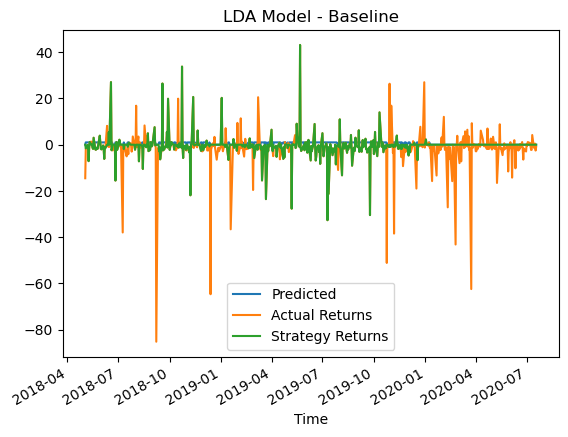

In [27]:
# Plot
predictions_sentiment_3_df.plot(title='LDA Model - Baseline')

# Save the plot as a JPG file
# plt.savefig('TSLA LinearDiscriminantAnalysis.jpg', format='jpg')

In [28]:
# Print the classification report
print(linear_disc_testing_report)

              precision    recall  f1-score   support

           0       0.48      0.50      0.49       268
           1       0.51      0.49      0.50       288

    accuracy                           0.49       556
   macro avg       0.49      0.49      0.49       556
weighted avg       0.50      0.49      0.49       556



#### Adjusted Model

In [29]:
# instantiate LinearDiscriminantAnalysis
lda_2_model = LinearDiscriminantAnalysis()

# Fit the model to the data using the training data
linear_disc_2_model = lda_2_model.fit(X2_train_scaled, y2_train)
 
# Use the testing data to make the model predictions
linear_disc_2_model = lda_2_model.predict(X2_test_scaled)

# Review the model's predicted values
linear_disc_2_model[:10]

# Use a classification report to evaluate the model using the predictions and testing data
linear_disc_2_testing_report = classification_report(y2_test, linear_disc_2_model)

predictions_sentiment_4_df = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_4_df['Predicted'] = linear_disc_2_model

# Add the actual returns to the DataFrame
predictions_sentiment_4_df['Actual Returns'] = sentiment_df['daily returns'].pct_change()

# Add the strategy returns to the DataFrame
predictions_sentiment_4_df['Strategy Returns'] = predictions_sentiment_4_df['Actual Returns'] * predictions_sentiment_4_df['Predicted']

# Review the DataFrame
display(predictions_sentiment_4_df.head())
display(predictions_sentiment_4_df.tail())

,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-06-06,0,-6.154480,-0.0
2018-06-07,0,-1.109524,-0.0
2018-06-08,0,-1.465382,-0.0
2018-06-11,0,8.151897,0.0
2018-06-12,0,-0.293207,-0.0


,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-07-13,0,-1.285677,-0.0
2020-07-14,0,-1.427979,-0.0
2020-07-15,0,0.460472,0.0
2020-07-16,0,-2.523894,-0.0
2020-07-17,0,-1.004542,-0.0


<Axes: title={'center': 'LDA Model - Adjusted'}, xlabel='Time'>

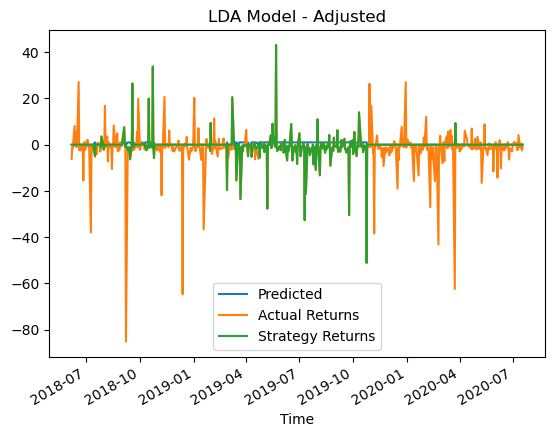

In [30]:
# Plot
predictions_sentiment_4_df.plot(title='LDA Model - Adjusted')

# Save the plot as a JPG file
# plt.savefig('TSLA LinearDiscriminantAnalysis.jpg', format='jpg')

In [31]:
# Print the classification report
print(linear_disc_2_testing_report)

              precision    recall  f1-score   support

           0       0.47      0.65      0.55       256
           1       0.50      0.33      0.40       277

    accuracy                           0.48       533
   macro avg       0.49      0.49      0.47       533
weighted avg       0.49      0.48      0.47       533



# <span style="color:blue">Results</span>

## Model #1 SVM

### Baseline

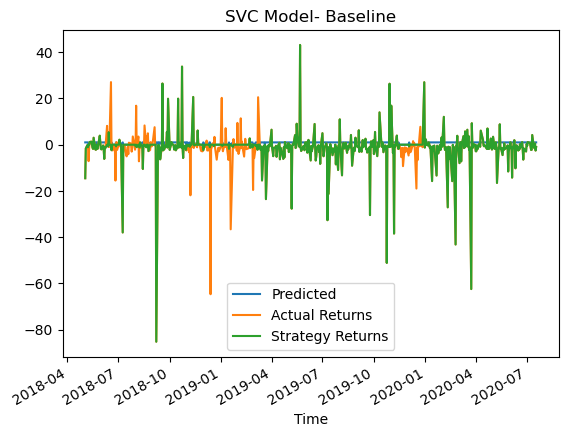

In [32]:
# plot
svc_baseline_plot = predictions_sentiment_df.plot(title='SVC Model- Baseline')

In [33]:
# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

           0       0.50      0.28      0.36       268
           1       0.52      0.74      0.61       288

    accuracy                           0.52       556
   macro avg       0.51      0.51      0.48       556
weighted avg       0.51      0.52      0.49       556



### <span style="color:Green"> Final Results </span>

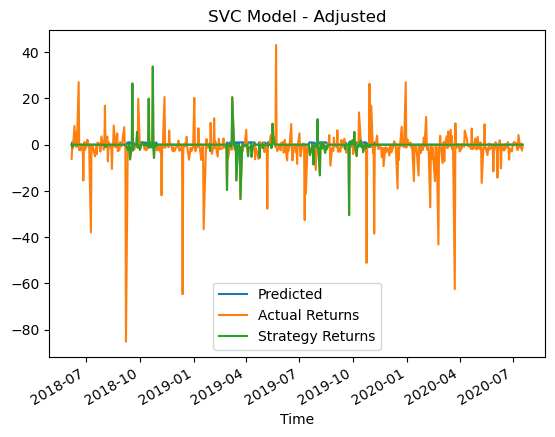

In [34]:
# plot
svc_adjusted_plot = predictions_sentiment_2_df.plot(title='SVC Model - Adjusted')

In [35]:
# Print the classification report
print(svm_2_testing_report)

              precision    recall  f1-score   support

           0       0.46      0.79      0.58       256
           1       0.42      0.14      0.21       277

    accuracy                           0.45       533
   macro avg       0.44      0.46      0.40       533
weighted avg       0.44      0.45      0.39       533



## Model #2 LDA

### Baseline

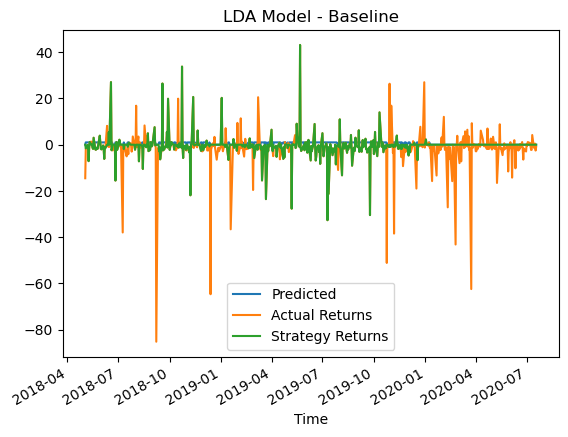

In [36]:
# Hvplot
lda_baseline_plot = predictions_sentiment_3_df.plot(title='LDA Model - Baseline')

In [37]:
# Print the classification report
print(linear_disc_testing_report)

              precision    recall  f1-score   support

           0       0.48      0.50      0.49       268
           1       0.51      0.49      0.50       288

    accuracy                           0.49       556
   macro avg       0.49      0.49      0.49       556
weighted avg       0.50      0.49      0.49       556



### <span style="color:Green"> Final Results </span>

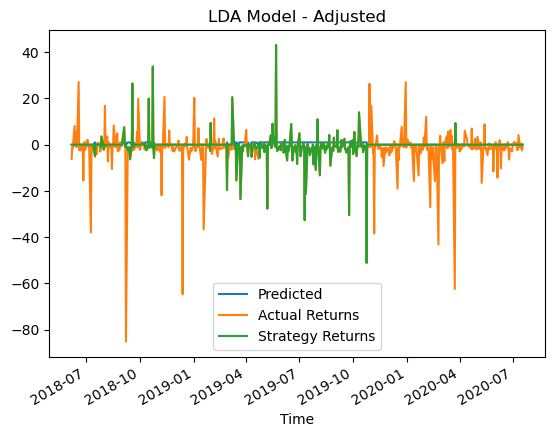

In [38]:
# Plot
lda_adjusted_plot = predictions_sentiment_4_df.plot(title='LDA Model - Adjusted')

In [39]:
# Print the classification report
print(linear_disc_2_testing_report)

              precision    recall  f1-score   support

           0       0.47      0.65      0.55       256
           1       0.50      0.33      0.40       277

    accuracy                           0.48       533
   macro avg       0.49      0.49      0.47       533
weighted avg       0.49      0.48      0.47       533



## Dashboard